In [1]:
## plot within the notebook
%matplotlib inline
import warnings
import numpy as np
## No annoying warnings
warnings.filterwarnings('ignore')

In [2]:
from astrobject.utils.plot.skybins import SurveyFieldBins
ztf_fields = np.genfromtxt('data/ZTF_Fields.txt', comments='%')
bins = SurveyFieldBins(ra=ztf_fields[:,1], dec=ztf_fields[:,2])
# Fields are defined by their midpoints
# Default width and height are set to 7 degrees for now
# There is more field overlap the closer you get to the poles

In [3]:
# Make a mock survey plan (by no means realistic, just trying to capture the effect of
# moving the observed part of the sky along according to the seasons)
import astrobject.simulation as simul
obs_days = np.arange(58000, 58181, 1)

dec_range = [-20, 60]
ra_range = [0, 90]
ra_shift = 360. / 365.25

t_obs = 60.
t_night = 8. * 3600

obs = {'time': [], 'field': [], 'band': [], 'skynoise': []}
for d in obs_days:
    # Find fields that have their center within dec_range and in ra_range shifted by ra_shift for each day
    field_idx = np.where((bins.ra > ra_range[0] + ra_shift * (d - obs_days[0])) &
                         (bins.ra < ra_range[1] + ra_shift * (d - obs_days[0])) &
                         (bins.dec > dec_range[0]) & (bins.dec < dec_range[1]))[0]
    
    # Sort first by ra then by dec
    field_idx = field_idx[np.argsort(bins.ra[field_idx])]
    field_idx = field_idx[np.argsort(bins.dec[field_idx])]

    for k, t in enumerate(np.arange(0, t_night, t_obs)):
        obs['time'].append(d + t / 86400.)
        obs['field'].append(field_idx[k % len(field_idx)])
        obs['band'].append(['desr', 'desg'][(k / len(field_idx)) % 2])
        obs['skynoise'].append(150.) # TBD later, completely random number for now
        
plan = simul.SurveyPlan(time=obs['time'], band=obs['band'], obs_field=obs['field'],
                        skynoise=obs['skynoise'],
                        fields=dict(ra=ztf_fields[:,1], dec=ztf_fields[:,2]))

{'ax': <matplotlib.projections.geo.MollweideAxes at 0x7fd5a3b8d550>,
 'cbar': <matplotlib.colorbar.ColorbarBase at 0x7fd5a365a510>,
 'collection': <matplotlib.collections.PolyCollection at 0x7fd5a376fcd0>,
 'figure': <matplotlib.figure.Figure at 0x7fd5a4044d50>}

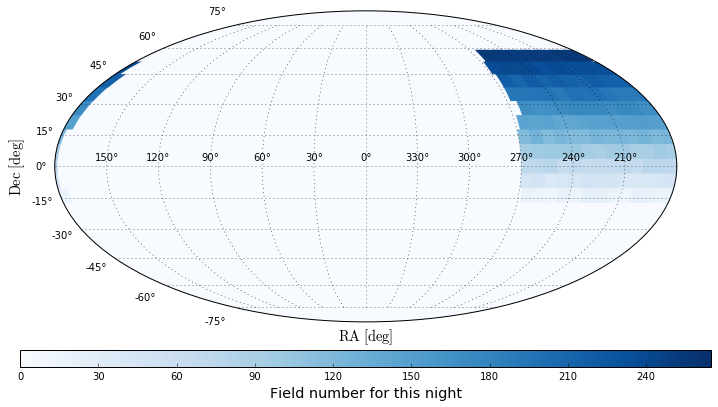

In [4]:
# Example of selected fields (last of the nights in the mock survey)
# The fields are number by the order in which they are observed.
vals = np.zeros(bins.nbins)
for k,l in enumerate(field_idx):
    vals[l] = k
    
bins.imshow(vals, cblabel="Field number for this night")

{'ax': <matplotlib.projections.geo.MollweideAxes at 0x7fd5a363efd0>,
 'cbar': <matplotlib.colorbar.ColorbarBase at 0x7fd5a1ba5ad0>,
 'collection': <matplotlib.collections.PolyCollection at 0x7fd5a3451890>,
 'figure': <matplotlib.figure.Figure at 0x7fd5a3717710>}

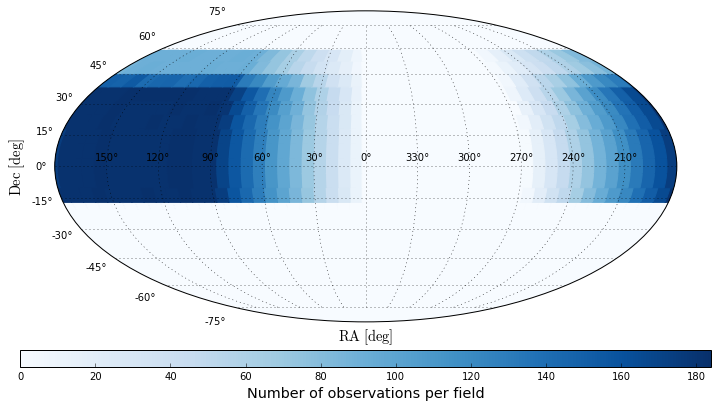

In [5]:
# Number of pointings per field
vals, _ = np.histogram(obs['field'], bins=range(bins.nbins + 1))
bins.imshow(vals, cblabel="Number of observations per field")

In [6]:
tr = simul.sn_generator([0.01,0.1], ratekind="basic", 
                        mjd_range=[obs_days[0] - 60, obs_days[-1] + 25])
# ratekind is the rate of the transient: basiclow = 1e3 
# -> comoving volumetric rate at each redshift in units of yr^-1 Mpc^-3.
# type_ is the type of transient. 
# This will parse the ratekind+type_ do get the good rate function

{'ax': <matplotlib.projections.geo.MollweideAxes at 0x7fd5a1aa0590>,
 'cbar': <matplotlib.colorbar.ColorbarBase at 0x7fd5a1978ad0>,
 'collection': <matplotlib.collections.PolyCollection at 0x7fd5a1b47250>,
 'figure': <matplotlib.figure.Figure at 0x7fd5a4044bd0>}

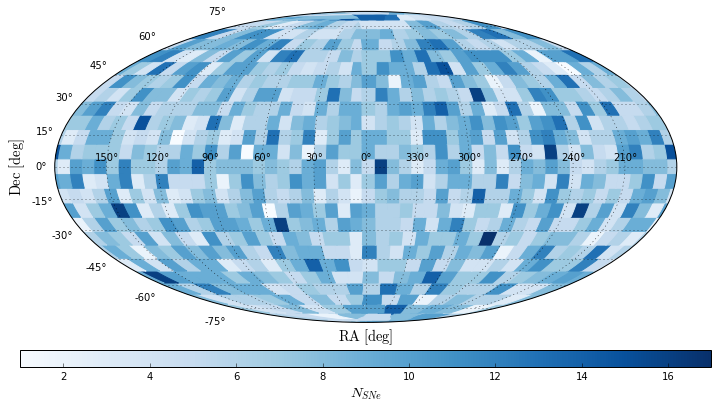

In [7]:
tr.hist_skycoverage(bins=bins)
# Since the fields can overlap, some SNe will be counted twice
# Overlapping fields partly obscure previously drawn 
# Some distortions when drawing fields near the poles (to be fixed later)

SNe observed: 1504 out of 6186


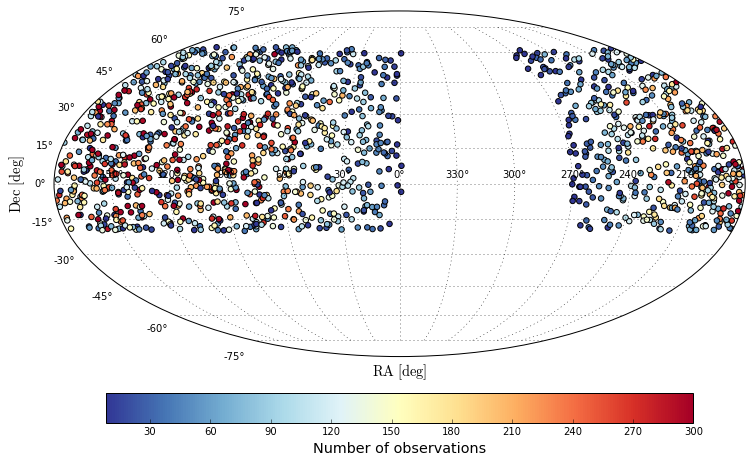

In [8]:
# SimulSurvey class collects all required components, Transient generator, survey plan and instruments
instprop = {"desg":{"gain":1,"zp":30,"zpsys":'ab'},
            "desr":{"gain":1,"zp":30,"zpsys":'ab'}}

survey = simul.SimulSurvey(generator=tr, plan=plan, instprop=instprop)

# Generate the lightcurves. This first determines the dates on which each transient was observed
# to keep the number of lightcurve points that are calculated to a minimum
lcs = survey.get_lightcurves()
n_obs = np.array([len(a) for a in survey.plan.observed])
survey.generator.show_skycoverage(cscale=n_obs, cblabel="Number of observations", mask=(n_obs > 0))
print 'SNe observed: %i out of %i'%(np.sum(n_obs > 0), survey.generator.ntransient)

In [21]:
# example lightcurve
lcs[19]

time,band,flux,fluxerr,zp,zpsys
float64,string32,float64,float64,int64,string16
58038.1416667,desr,182.74609674,150.0,30,ab
58038.1527778,desr,-3.56407731141,150.0,30,ab
58038.3263889,desg,263.530562097,150.0,30,ab
58039.1423611,desr,58.7811430278,150.026204935,30,ab
58039.1493056,desr,70.9882736956,150.02762912,30,ab
58039.3256944,desg,-265.259319541,150.04450985,30,ab
58039.3326389,desg,143.857769365,150.045937479,30,ab
58040.1388889,desr,317.13755097,150.591909777,30,ab
58040.1493056,desr,-78.6408283138,150.601651777,30,ab


In [22]:
# Its parameters
lcs[19].meta

{'c': 0.023852814932371777,
 'mwebv': 0.1360507607460022,
 't0': 58059.713348597033,
 'x0': 0.0017033577975229877,
 'x1': -0.28349957695544725,
 'z': 0.04573029570503}

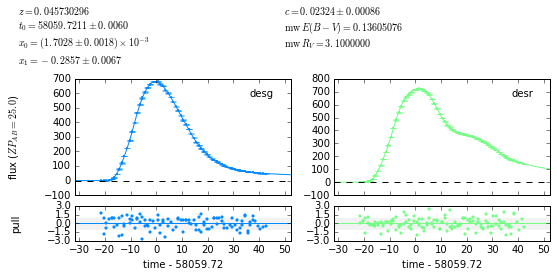

In [23]:
# Example lightcurve fit
lc = lcs[19]

import sncosmo
survey.generator.model.set(z=lc.meta['z'],mwebv=lc.meta['mwebv'])
res, fitted_model = sncosmo.fit_lc(lc, survey.generator.model, ['t0', 'x0', 'x1', 'c'])

_ = sncosmo.plot_lc(lc, model=fitted_model, errors=res.errors)

{'ax': <matplotlib.projections.geo.MollweideAxes at 0x7fd5a0f2bf90>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x7fd5a116e8d0>,
 'figure': <matplotlib.figure.Figure at 0x7fd5a1326f90>,
 'plot': <matplotlib.collections.PathCollection at 0x7fd5a116e050>}

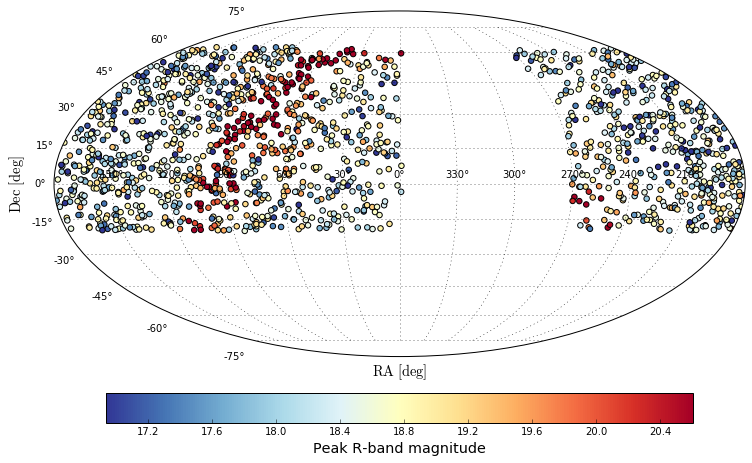

In [24]:
# MW E(B-V) is now automatically included in the lc model,
# so MW can be seen in magnitudes
peak_mag = survey.generator.get_bandmag(band='bessellr', magsys='vega', t=0) # t is time relative to t0
survey.generator.show_skycoverage(cscale=peak_mag, cblabel="Peak R-band magnitude", mask=(n_obs > 0))

{'ax': <matplotlib.projections.geo.MollweideAxes at 0x7fd5a1678d10>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x7fd5a0f66050>,
 'figure': <matplotlib.figure.Figure at 0x7fd5a12fba10>,
 'plot': <matplotlib.collections.PathCollection at 0x7fd5a0f58810>}

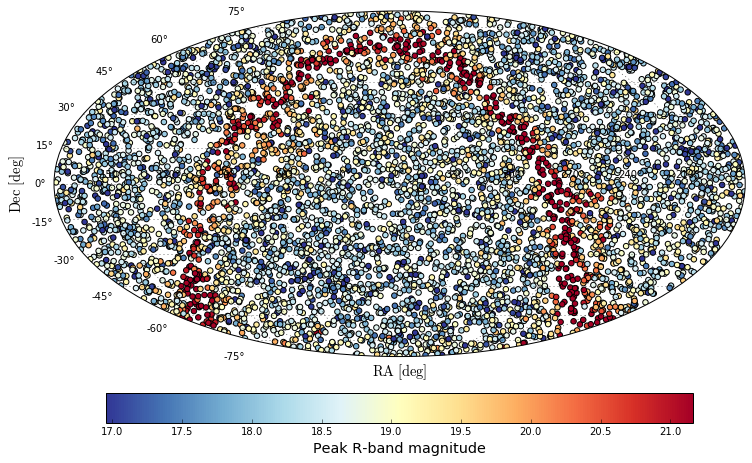

In [25]:
# It's more obvious when using the whole sample
survey.generator.show_skycoverage(cscale=peak_mag, cblabel="Peak R-band magnitude")